In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import *
from matplotlib.colors import TwoSlopeNorm
# import matplotlib.pyplot as plt
import numpy as np
from dysts_simulation import VanDerPol
# from scipy.stats import mannwhitneyu
# import sys
from tqdm.auto import tqdm

# sys.path.append('/om2/user/eisenaj/code/CommunicationTransformer')


# Simulating the Damped Van der Pol Oscillator

Welcome to the DeLASE tutorial Jupyter notebook! In this notebook, we'll begin by simulating the data we'll be analzying. The data is going to come from the Van der Pol oscillator, a simple model of a nonlinear oscillator that exhibits limit cycle behavior. The Van der Pol oscillator is described by the following system of ordinary differential equations:

$$ \dot{x} = y $$
$$ \dot{y} = \mu(1 - x^2)y - x $$

We can adapt this system to include damping by adding a damping term to the second equation:

$$ \dot{x} = y $$
$$ \dot{y} = \mu(1 - x^2)y - x - \gamma y $$

Now, if $\gamma$ is larger than $\mu$ the system will no longer exhibit a limit cycle, and will instead collapse to a fixed point. This means that the Lyapunov exponent will no longer be 0 (as it is for a limit cycle), but will instead be negative. We can use this to test our stability analysis code, as the system should get more stable as $\gamma$ increases beyond $\mu$ (that is, it will converge to the fixed point faster).

To simulate the Van der Pol oscillator, I'm using an adapted version of this [`dysts`](https://github.com/williamgilpin/dysts) package by William Gilpin. This package is designed to simulate chaotic dynamical systems in a standardized way, I highly recommend checking it out!

In [18]:
num_trajs = 5
n_periods = 20
pts_per_period = 500
T = n_periods*pts_per_period
param_list = [(2, 0), (2, 2.02), (2, 2.04)]
traj_offset_sd = 1e-1
random_state = 42
param_name = "\mu, \gamma"
noise = 0
transient = int(0.1*T)
train_window = int(0.6*T)
test_window = int(0.3*T)
obs_noise = 0

trajectories = {}
eqs = {}
for param in param_list:  
    params = dict(
        mu=param[0],
        gamma=param[1]
    )
    print(f"Simulating parameters: mu: {params['mu']}, gamma: {params['gamma']}")
    eq = VanDerPol(**params, random_state=random_state)
    eqs[param] = eq
    trajectories[param] = eq.make_trajectory(n_periods=n_periods, num_ics=num_trajs, pts_per_period=pts_per_period, noise=noise, traj_offset_sd=traj_offset_sd, verbose=True)
    trajectories[param] += np.random.randn(*trajectories[param].shape)*obs_noise

Simulating parameters: mu: 2, gamma: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Simulating parameters: mu: 2, gamma: 2.02


  0%|          | 0/5 [00:00<?, ?it/s]

Simulating parameters: mu: 2, gamma: 2.04


  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
dt = eq.period/pts_per_period
t_inds = np.arange(n_periods*pts_per_period)
t_eval = t_inds*dt

train_inds = np.arange(transient, transient + train_window)
test_inds = np.arange(transient + train_window, transient + train_window + test_window)

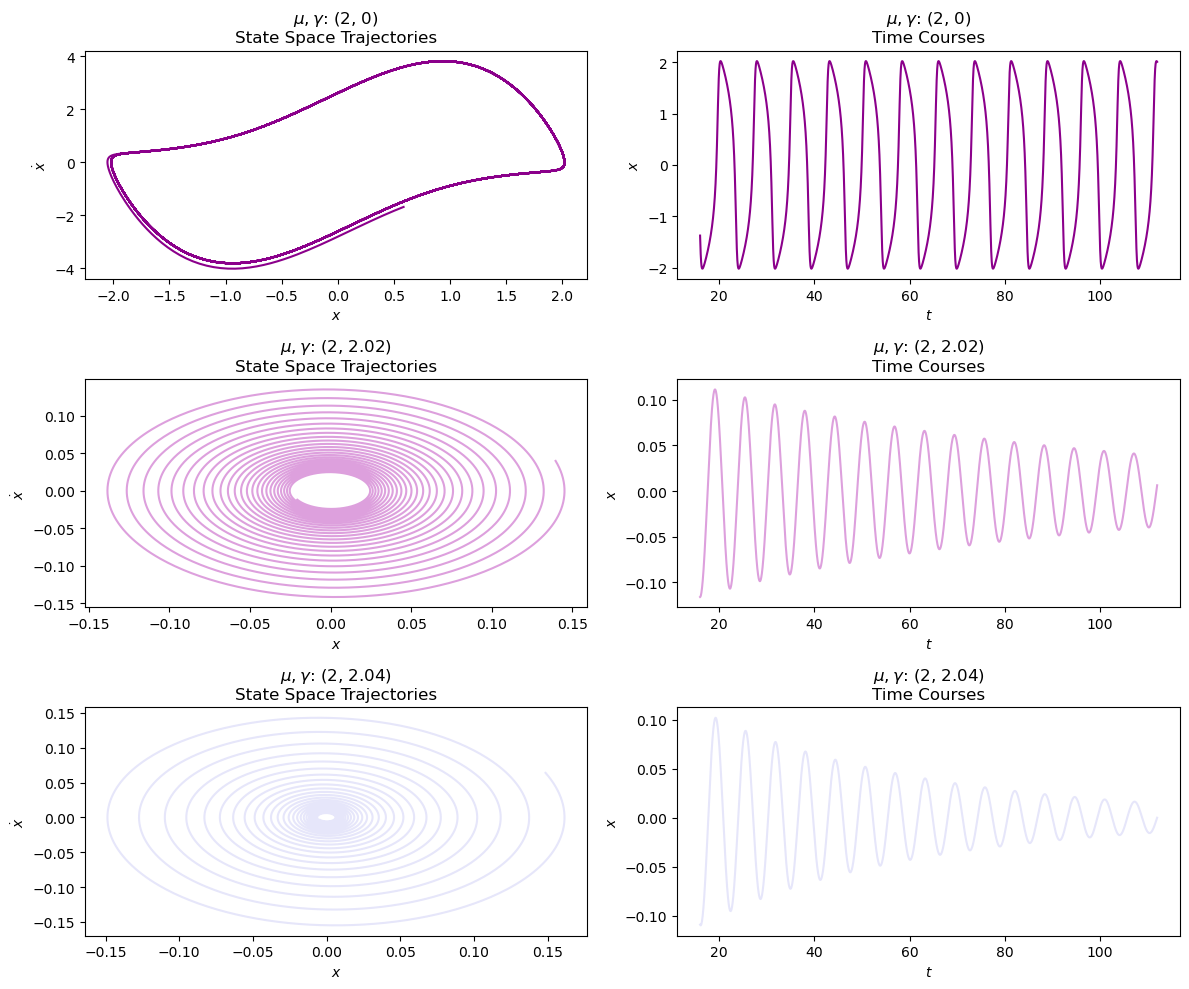

In [20]:

colors = ['darkmagenta', 'plum', 'lavender']
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
traj_num = -1
# axs[0] = fig.add_subplot(1, 2, 1, projection='3d')
for ind, (param, x) in enumerate(trajectories.items()):
        ax = axs[ind][0]
        ax.plot(x[traj_num, :, 0], x[traj_num, :, 1], c=colors[ind])

        ax = axs[ind][1]
        ax.plot(t_eval[train_inds], x[traj_num, train_inds, 0], label=f"${param_name}$: {param}", c=colors[ind])
        
        axs[ind][0].set_title(f"${param_name}$: {param}\nState Space Trajectories")
        axs[ind][0].set_xlabel("$x$")
        axs[ind][0].set_ylabel("$\dot{x}$")
        axs[ind][1].set_title(f"${param_name}$: {param}\nTime Courses")
        axs[ind][1].set_xlabel("$t$")
        axs[ind][1].set_ylabel("$x$")


# axs[0].set_title("State Space Trajectories")
# axs[0].set_xlabel("$x$")
# axs[0].set_ylabel("$\dot{x}$")
# axs[1].set_title("Time Courses")
# axs[1].set_xlabel("$t$")
# axs[1].set_ylabel("$x$")
# plt.legend()
plt.tight_layout()
plt.show()

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

max_freq = (1/(dt))/2 # the maximum frequency that can be detected in the data is the Nyquist frequency - thus we filter out all delay differential equation roots with a frequency greater than this value

n_delays_vals = [1, 2, 3, 4, 5, 6, 7, 8]
rank_vals = [1, 2, 3, 4, 5, 6, 7, 8]

# n_delays_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# rank_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


all_delase_results = []

iterator = tqdm(total=num_trajs*len(param_list)*len(n_delays_vals)*len(rank_vals))

for num_traj in range(num_trajs):
    # print("-"*20)
    # print(f"NUM_TRAJ = {num_traj}")
    delase_results = {}
    
    for param in param_list:
        # print("-"*20)
        # print(f"MU = {mu}")
        x = trajectories[param]
        x = x[num_traj]
        # x = x[::subsample]
        x = x[:, [0]] # only observe one dimension!
        
        aic_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        mase_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat2 = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat10p = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals_mat2 = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals_mat10p = np.zeros((len(n_delays_vals), len(rank_vals)))
        
        for i, n_delays in enumerate(n_delays_vals):
            delase = DeLASE(x[train_inds], n_delays=n_delays, rank=n_delays*x.shape[-1], dt=dt, max_freq=max_freq, max_unstable_freq=max_freq, device=device)
            delase.DMD.compute_hankel()
            delase.DMD.compute_svd()
            for j, rank in enumerate(rank_vals):
                if rank <= n_delays*x.shape[-1]:
                    
                    delase.DMD.compute_havok_dmd(rank=rank)
                    preds = delase.DMD.predict(x[test_inds])
                    aic_mat[i, j] = float(aic(torch.from_numpy(x[test_inds]).cuda(), preds, k=rank**2).cpu().numpy())
                    mase_mat[i, j] = float(mase(torch.from_numpy(x[test_inds]).cuda(), preds).cpu().numpy())
                    delase.get_stability()
                    stab_mean_mat2[i, j] = delase.stability_params[:2].mean().cpu().numpy()
                    num_params = np.min((int(0.1*len(delase.stability_params)), rank))
                    num_params = np.max([num_params, 1])
                    stab_mean_mat10p[i, j] = delase.stability_params[:num_params].mean().cpu().numpy()

                    I = torch.eye(delase.DMD.A_havok_dmd.shape[0]).cuda()
                    evals = torch.linalg.eigvals((delase.DMD.A_havok_dmd - I)/dt)
                    evals, freqs = torch.real(evals), torch.imag(evals)/(2*np.pi)
                    sort_inds = torch.flip(torch.sort(evals).indices, dims=(0,))
                    evals, freqs = evals[sort_inds], freqs[sort_inds]
                    freq_inds = freqs <= max_freq
                    evals = evals[freq_inds]
                    freqs = freqs[freq_inds]
                    delase_evals_mat2[i, j] = evals[:2].mean().cpu().numpy()
                    num_evals = np.min((int(0.1*len(evals)), rank))
                    num_evals = np.max([num_evals, 1])
                    delase_evals_mat10p[i, j] = evals[:num_evals].mean().cpu().numpy()
                    
                else:
                    aic_mat[i, j] = np.inf
                    mase_mat[i, j] = np.inf
                iterator.update()
    
        delase_results[param] = dict(
            train_inds=train_inds,
            test_inds=test_inds,
            aic_mat=aic_mat,
            mase_mat=mase_mat,
            stab_mean_mat2=stab_mean_mat2,
            stab_mean_mat10p=stab_mean_mat10p,
            delase_evals_mat2=delase_evals_mat2,
            delase_evals_mat10p = delase_evals_mat10p
        )

    all_delase_results.append(delase_results)
    
iterator.close()

  0%|          | 0/960 [00:00<?, ?it/s]

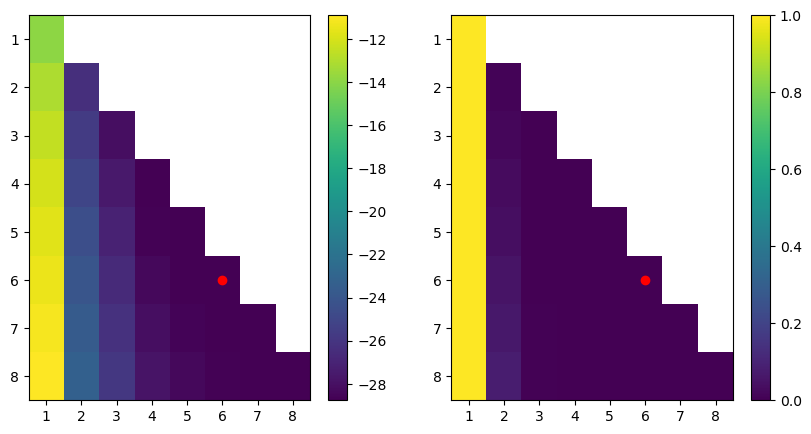

In [22]:
params_to_use = param_list
# params_to_use = [(1, 0), (2, 0), (3, 0), (1, 2)]

aic_mat_all = np.ones((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
mase_mat_all = np.ones((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, param in enumerate(params_to_use):
        aic_mat_all[num_traj, ind] = delase_results[param]['aic_mat']
        mase_mat_all[num_traj, ind] = delase_results[param]['mase_mat']
# aic_mat /= len(rhos_to_use)
aic_mat = aic_mat_all.mean(axis=(0, 1))
mase_mat = mase_mat_all.mean(axis=(0, 1))
i, j = np.unravel_index(aic_mat.argmin(), shape=aic_mat.shape)
# i, j = np.unravel_index(mase_mat.argmin(), shape=aic_mat.shape)
n_delays = n_delays_vals[i]
rank = rank_vals[j]
# n_delays = 200
# rank = 15
# rank = 12
# rank = 8
# j = np.where(np.array(rank_vals) == rank)[0][0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
im = ax.imshow(aic_mat, aspect='auto')
ax.scatter(j, i, c='r')
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)

ax = axs[1]
norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
im = ax.imshow(mase_mat, aspect='auto', norm=norm)
ax.scatter(j, i, c='r')
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)
plt.show()

In [23]:
# Collect the results

stab_means_2 = np.zeros((num_trajs, len(params_to_use)))
stab_means_10p = np.zeros((num_trajs, len(params_to_use)))
delase_evals_2 = np.zeros((num_trajs, len(params_to_use)))
delase_evals_10p = np.zeros((num_trajs, len(params_to_use)))

for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, param in enumerate(params_to_use):
        stab_means_2[num_traj, ind] = delase_results[param]['stab_mean_mat2'][i, j]
        stab_means_10p[num_traj, ind] = delase_results[param]['stab_mean_mat10p'][i, j]
        delase_evals_2[num_traj, ind] = delase_results[param]['delase_evals_mat2'][i, j]
        delase_evals_10p[num_traj, ind] = delase_results[param]['delase_evals_mat10p'][i, j]

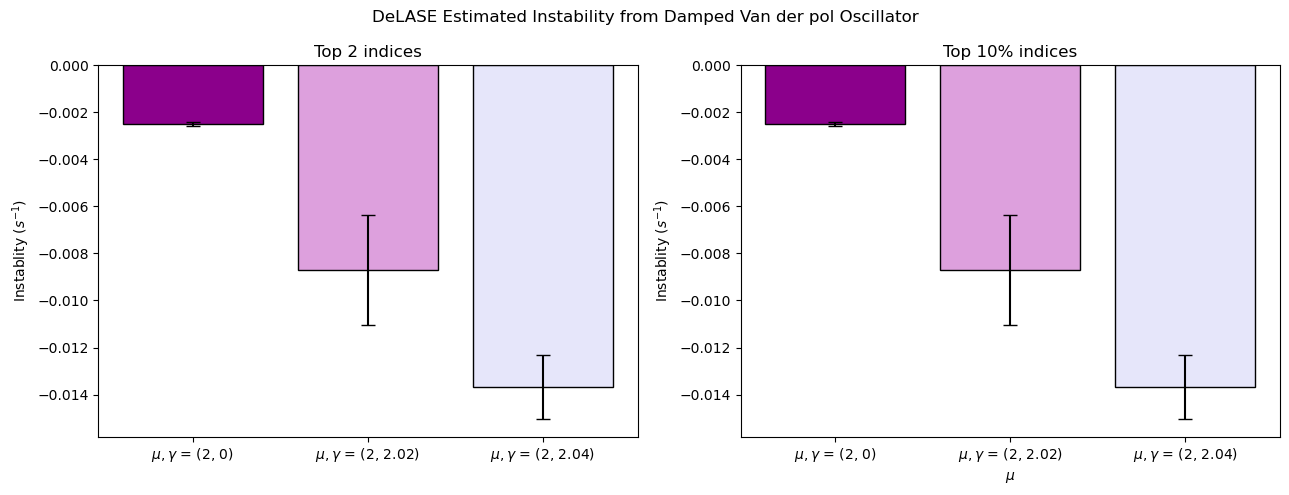

In [24]:


# Create the scatter plot with error bars

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

ax = axs[0]
mean_vals = stab_means_2.mean(axis=0)
se_vals = stab_means_2.std(axis=0)/np.sqrt(stab_means_2.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

# ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 2 indices")

ax = axs[1]
mean_vals = stab_means_10p.mean(axis=0)
se_vals = stab_means_10p.std(axis=0)/np.sqrt(stab_means_10p.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 10% indices")

fig.suptitle("DeLASE Estimated Instability from Damped Van der pol Oscillator")

# Create legend
plt.tight_layout()
plt.show()

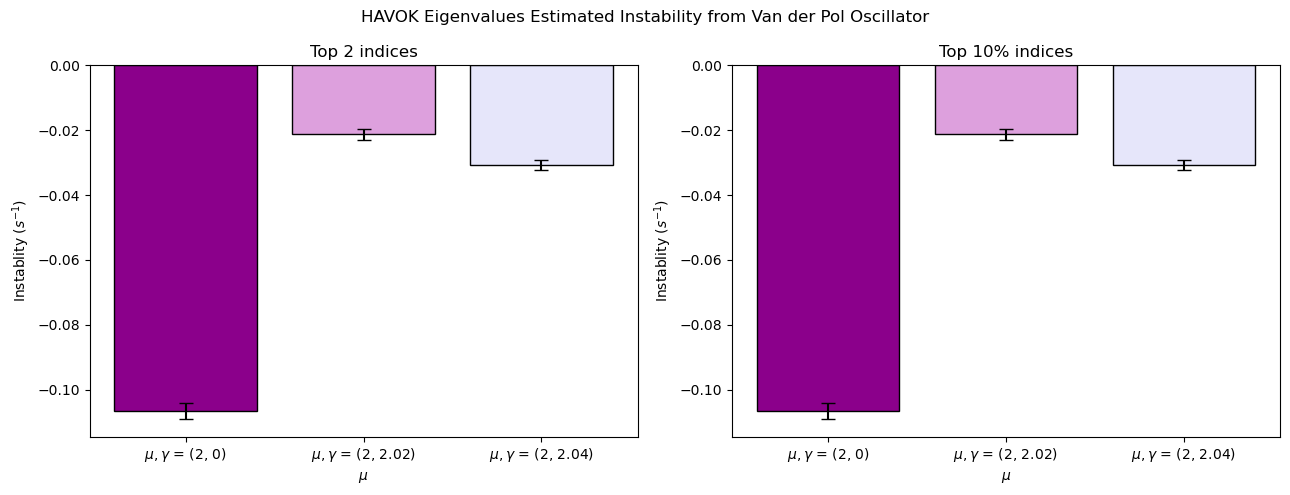

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

ax = axs[0]
mean_vals = delase_evals_2.mean(axis=0)
se_vals = delase_evals_2.std(axis=0)/np.sqrt(delase_evals_2.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 2 indices")

ax = axs[1]
mean_vals = delase_evals_10p.mean(axis=0)
se_vals = delase_evals_10p.std(axis=0)/np.sqrt(delase_evals_10p.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 10% indices")

fig.suptitle("HAVOK Eigenvalues Estimated Instability from Van der Pol Oscillator")

plt.tight_layout()
plt.show()

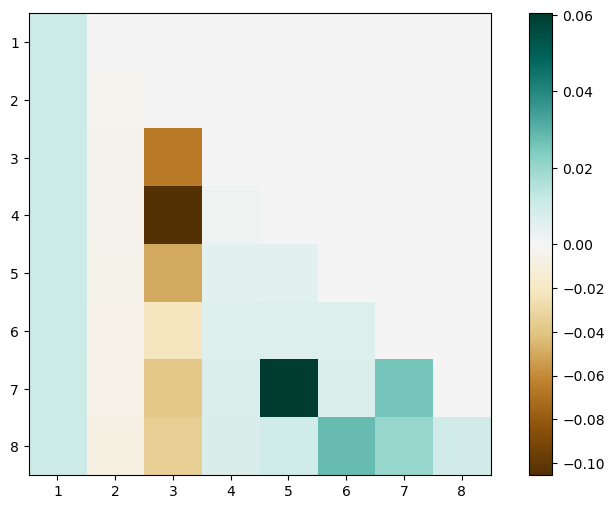

In [61]:
system1_ind = 0
system2_ind = 1

stab_means_all = np.zeros((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
# delase_evals_all = np.zeros((num_trajs, len(rhos_to_use), len(n_delays_vals), len(rank_vals)))
for i in range(len(n_delays_vals)):
    for j in range(len(rank_vals)):
        for num_traj in range(num_trajs):
            delase_results = all_delase_results[num_traj]
            for ind, param in enumerate(params_to_use):
                stab_means_all[num_traj, ind] = delase_results[param]['stab_mean_mat10p']
                # stab_means_all[num_traj, ind] = delase_results[param]['stab_mean_mat10p']
            

# fig, axs = plt.subplots(len(n_delays_vals), len(rank_vals), figsize=(20, 12))

stab_all_mean = stab_means_all.mean(axis=0)
stab_all_se = stab_means_all.std(axis=0)/np.sqrt(num_trajs)

diff = stab_all_mean[system1_ind] - stab_all_mean[system2_ind]
if diff.min() == 0:
    norm = TwoSlopeNorm(vmin=diff.min() - diff.max(), vcenter=0, vmax=diff.max())
else:
    norm = TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=diff.max())
# norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
plt.figure(figsize=(10, 6))
plt.imshow(diff, cmap='BrBG', norm=norm)
plt.xticks(np.arange(len(rank_vals)), rank_vals)
plt.yticks(np.arange(len(n_delays_vals)), n_delays_vals)
plt.colorbar()

plt.show()

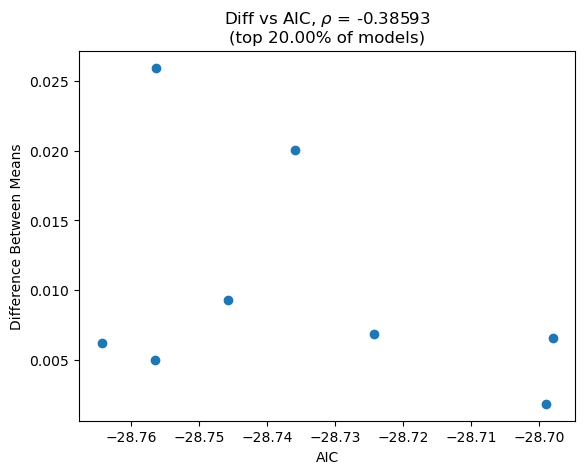

In [63]:
from scipy.stats import pearsonr

top_percent = 0.2
aic_min = aic_mat[aic_mat < np.inf].min()
aic_max = np.percentile(aic_mat[aic_mat < np.inf], top_percent*100)
aic_all = aic_mat[aic_mat < np.inf].flatten()
diff_all = diff[aic_mat < np.inf].flatten()
aic_inds = (aic_all >= aic_min) & (aic_all <= aic_max)

plt.scatter(aic_all[aic_inds], diff_all[aic_inds] )
plt.xlabel('AIC')
plt.ylabel('Difference Between Means')

# lr = LinearRegression().fit(aic_all[aic_inds].reshape(-1, 1), diff_all[aic_inds].reshape(-1, 1))
# rho = np.sqrt(lr.score(aic_all[aic_inds].reshape(-1, 1), diff_all[aic_inds].reshape(-1, 1)))
rho = pearsonr(aic_all[aic_inds], diff_all[aic_inds]).statistic
# print(lr.coef_)
plt.title(fr"Diff vs AIC, $\rho$ = {rho:.5f}"+ f"\n(top {top_percent*100:.2f}% of models)")

plt.show()